In [135]:
# Importing libraries
import numpy as np
import os,cmath,sys
import skimage
import matplotlib
import matplotlib.pyplot as plt
from numpy.fft import fft,fft2,ifft,ifft2,fftshift,ifftshift
from math import sqrt,exp,pi,cos,sin
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.cm as cm
import cv2
from time import time
from matplotlib.image import imread
from scipy.ndimage.interpolation import rotate
from matplotlib.colors import LogNorm
from scipy.signal import convolve2d
from scipy.ndimage import gaussian_filter
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,15)
plt.rcParams["figure.dpi"] = 40

In [136]:
def rgb2gray(image):
    '''
    A function that takes in input an image and returns its greyscale version
    '''
    if (len(image.shape)==2):
        return image
    elif (len(image.shape)==3):
        r = image[:,:,0]
        g = image[:,:,1]
        b = image[:,:,2]
        output = 0.2989 * r + 0.5870 * g + 0.1140 * b
        return output

In [137]:
def bilfilt(image, smooth1, smooth2,ksize):
    '''
    '''
    vard = smooth1
    varr = smooth2
    if (len(image.shape)==2):
        pad_im = np.zeros([image.shape[0]+ksize,image.shape[1]+ksize])
        pad_im[0:image.shape[0],0:image.shape[1]] = image
        output = np.zeros(image.shape)
        dom = np.zeros([ksize,ksize])
        for i in range(0, ksize,1):
            for j in range(0, ksize,1):
                dom[i,j] = (exp(-((i-(ksize//2))**2 + (j-(ksize//2))**2)/(2*vard))/(2*pi*np.sqrt(vard)))
                
        for i in range(0, image.shape[0],1):
            for j in range(0, image.shape[1],1):
                normalisation = 0
                for k in range(i,i+ksize):
                    for l in range(j, j+ksize):
                        ran = (exp(-((pad_im[i,j] - pad_im[k,l])**2)/(2*varr))/(2*pi*np.sqrt(varr)))
                        weight = dom[k-i,l-j]*ran
                        output[i,j]+=pad_im[k,l]*weight
                        normalisation += weight
                output[i,j]=output[i,j]/normalisation
        return output
    
def bilfilt_wrap(image, sigma1, sigma2, ksize = 3):
    output=np.zeros(image.shape)
    if (len(image.shape)==2):
        output = bilfilt(image, sigma1, sigma2, ksize)
    elif (len(image.shape)==3):
        output[:,:,0] = bilfilt(image[:,:,0],sigma1,sigma2,ksize)
        output[:,:,1] = bilfilt(image[:,:,1],sigma1,sigma2,ksize)
        output[:,:,2] = bilfilt(image[:,:,2],sigma1,sigma2,ksize)
        
    return np.round(output).astype('uint8')

In [169]:
def histEqualization(im):
    """
    """
    output = np.zeros(im.shape)
    hist, bins = np.histogram(im, np.arange(0,257,1))
    totPix = im.shape[0]*im.shape[1]
    prob = hist/totPix
    cdf = prob.cumsum()
    cdf_norm = (cdf-np.amin(cdf))*255/(np.amax(cdf)-np.amin(cdf))
    cdf_norm = cdf_norm.astype('uint8')
    flattened_op = np.round(cdf_norm[im.flatten()])
    output = np.reshape(flattened_op, im.shape)
    return output.astype('uint8')

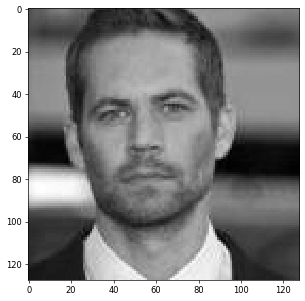

In [138]:
file = os.path.join(os.getcwd(), 'Image data/Face/im14.jpg')
vin = rgb2gray(imread(file)).astype('uint8')
fig = plt.figure(figsize = [6,6], dpi = 60)
ax = fig.add_subplot(111)
ax.imshow(vin, interpolation = None, cmap = 'gray')
plt.show()

In [197]:
vin = histEqualization(vin) 
filtered_image_cv2 = cv2.bilateralFilter(vin, 2, 1.8, 1.8)
# filt_im = bilfilt_wrap(vin, 1.8, 30.0 ,5)

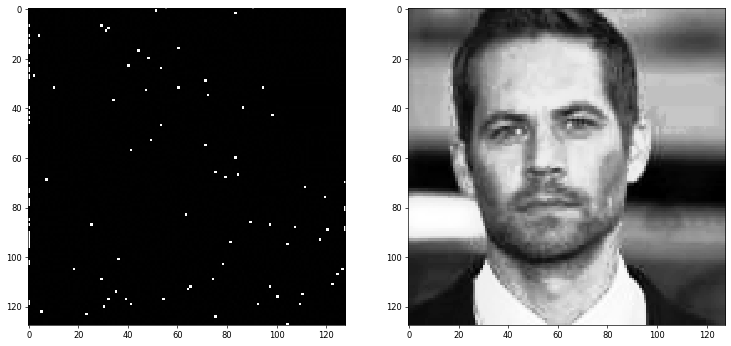

In [198]:
# filt_im = (filt_im - np.min(filt_im))/(np.max(filt_im) - np.min(filt_im))
# fig1 = plt.figure(figsize = [15,15], dpi = 60)
# ax1 = fig1.add_subplot(121)
# ax1.imshow(vin - filtered_image_cv2, interpolation = None)
# ax2 = fig1.add_subplot(122)
# ax2.imshow(filtered_image_cv2, interpolation = None)
base_layer = filtered_image_cv2
detail_layer = vin - filtered_image_cv2
# vin = 255*(vin-np.min(vin))/(np.max(vin)-np.min(vin))
# base_layer = 255*(base_layer-np.min(base_layer))/(np.max(base_layer)-np.min(base_layer))
# detail_layer = (detail_layer-np.min(detail_layer))

fig2 = plt.figure(figsize = [15,15], dpi = 60)
ax1 = fig2.add_subplot(121)
ax1.imshow(detail_layer, interpolation = None, cmap = 'gray')
ax2 = fig2.add_subplot(122)
ax2.imshow(base_layer, interpolation = None, cmap = 'gray')
plt.show()

In [199]:
sobel_x = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
sobel_y = np.array([[-1,0,1],[-2,0,2],[-1,0,1]]).T

sobelx_grad_detail = convolve2d(detail_layer,sobel_x, mode = 'same')
sobely_grad_detail = convolve2d(detail_layer,sobel_y, mode = 'same')

sobelx_grad_base = convolve2d(base_layer,sobel_x, mode = 'same')
sobely_grad_base = convolve2d(base_layer,sobel_y, mode = 'same')

energy_grad_detail = np.sqrt(np.add(np.square(sobelx_grad_detail),np.square(sobely_grad_detail)))
energy_grad_base = np.sqrt(np.add(np.square(sobelx_grad_base),np.square(sobely_grad_base)))



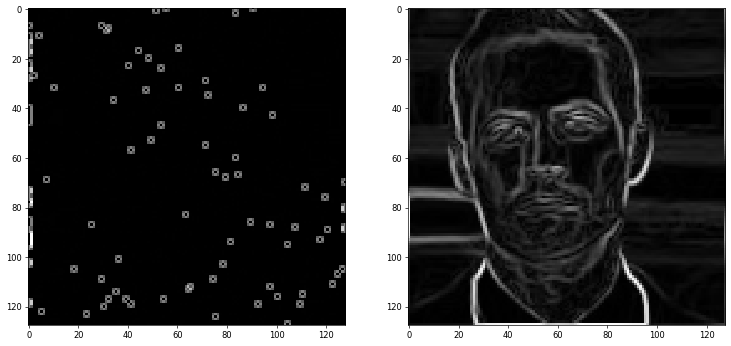

In [201]:
fig2 = plt.figure(figsize = [15,15], dpi = 60)
ax1 = fig2.add_subplot(121)
ax1.imshow(energy_grad_detail, interpolation = None, cmap = 'gray')
ax2 = fig2.add_subplot(122)
ax2.imshow(energy_grad_base, interpolation = None, cmap = 'gray')
plt.show()

In [202]:
regularise = np.sum(np.square(np.abs(energy_grad_base)))/np.sum(np.square(np.abs(energy_grad_detail)))

numer = np.multiply(detail_layer, np.square(np.abs(energy_grad_base)))
denom = np.add(np.square(np.abs(energy_grad_base)),regularise*np.square(energy_grad_detail))

non_lin_filt_detail_layer = (0.01+numer)/(0.01+denom)

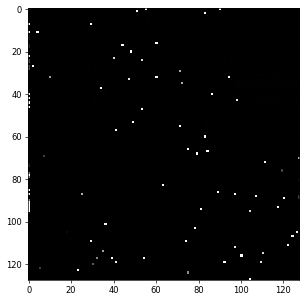

In [203]:
fig2 = plt.figure(figsize = [6,6], dpi = 60)
ax1 = fig2.add_subplot(111)
ax1.imshow(non_lin_filt_detail_layer, interpolation = None, cmap = 'gray')
plt.show()

In [204]:
def edge_interpolate_per_pixel(im, x, y):
#     x = np.asarray(x)
#     y = np.asarray(y)
    
    x0 = np.floor(x).astype(int)
    x1 = x0 + 1
    y0 = np.floor(y).astype(int)
    y1 = y0 + 1

    x0 = np.clip(x0, 0, im.shape[0]-1);
    x1 = np.clip(x1, 0, im.shape[0]-1);
    y0 = np.clip(y0, 0, im.shape[1]-1);
    y1 = np.clip(y1, 0, im.shape[1]-1);

#     Ia = im[ y0, x0 ]
#     Ib = im[ y1, x0 ]
#     Ic = im[ y0, x1 ]
#     Id = im[ y1y= x1 ]

#     wa = (x1-x) * (y1-y)
#     wb = (x1-x) * (y-y0)
#     wc = (x-x0) * (y1-y)
#     wd = (x-x0) * (y-y0)
#     diag1_dir = np.abs(Ia - Id)
#     diag2_dir = np.abs(Ib - Ic)
    diag1_dir = np.abs(im[x0,y0]-im[x1,y1])
    diag2_dir = np.abs(im[x1,y0]-im[x0,y1])
    if(diag1_dir<diag2_dir):
        out = (im[x0,y0]+im[x1,y1])/2
    else:
        out = (im[x0,y1]+im[x1,y0])/2
    
    return np.round(out)
#     return wa*Ia + wb*Ib + wc*Ic + wd*Id

def edge_interpolation(image, new_r,new_c):
    r,c = image.shape
    image = image.astype('float')
    factorx,factory = new_r/r, new_c/c
    output = np.zeros((new_r,new_c), dtype = 'float')
#     for i in range(r):
#         for j in range(c):
#             if (np.round(i*factorx)-i*factorx == 0 and np.round(j*factorx)-j*factorx == 0):
#                 print(np.round(i*factorx).astype('int'),np.round(j*factory).astype('int'))
#                 output[np.round(i*factorx).astype('int'),np.round(j*factory).astype('int')] = image[i,j]
#     for i in range(new_r):
#         for j in range(new_c):
#             if (output[i,j]==0):
#                 output[i,j] = edge_interpolate_per_pixel(image,i,j)
    x_new = np.linspace(0,r-1,new_r)
    y_new = np.linspace(0,c-1,new_c)
    
    for i in range(new_r):
        for j in range(new_c):
            if (x_new[i]-int(x_new[i]) == 0 and y_new[j]-int(y_new[j]) == 0):
                output[i,j] = image[int(x_new[i]),int(y_new[j])]
    
    for i in range(new_r):
        for j in range(new_c):
            if (output[i,j] == 0):
                output[i,j] = edge_interpolate_per_pixel(image, x_new[i], y_new[j])
    return output

In [205]:
new_shape = 200
interp_img_base = edge_interpolation(base_layer, new_shape, new_shape)
interp_img_detail = edge_interpolation(non_lin_filt_detail_layer, new_shape, new_shape)

sobelx_grad_interp_detail = convolve2d(interp_img_detail,sobel_x, mode = 'same')
sobely_grad_interp_detail = convolve2d(interp_img_detail,sobel_y, mode = 'same')

sobelx_grad_interp_base = convolve2d(interp_img_base,sobel_x, mode = 'same')
sobely_grad_interp_base = convolve2d(interp_img_base,sobel_y, mode = 'same')

energy_grad_interp_detail = np.sqrt(np.add(np.square(sobelx_grad_interp_detail),np.square(sobely_grad_interp_detail)))
energy_grad_interp_base = np.sqrt(np.add(np.square(sobelx_grad_interp_base),np.square(sobely_grad_interp_base)))

enhance = 1+(0.01+np.abs(energy_grad_interp_base))/(0.01+np.abs(energy_grad_interp_detail))
enhance = np.clip(enhance,0,energy_grad_interp_base)

interpolated_image = interp_img_base + np.multiply(enhance, interp_img_detail)

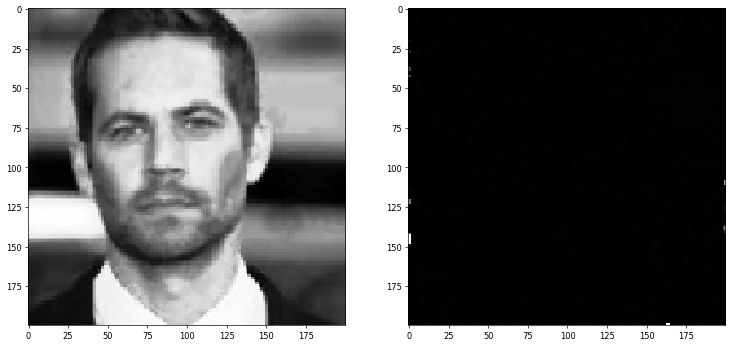

In [206]:
fig2 = plt.figure(figsize = [15,15], dpi = 60)
ax1 = fig2.add_subplot(121)
ax1.imshow(np.floor(interp_img_base).astype('uint8'), interpolation = None, cmap = 'gray')
ax2 = fig2.add_subplot(122)
ax2.imshow((interp_img_detail-np.min(interp_img_detail)).astype('uint8'), interpolation = None, cmap = 'gray')
plt.show()

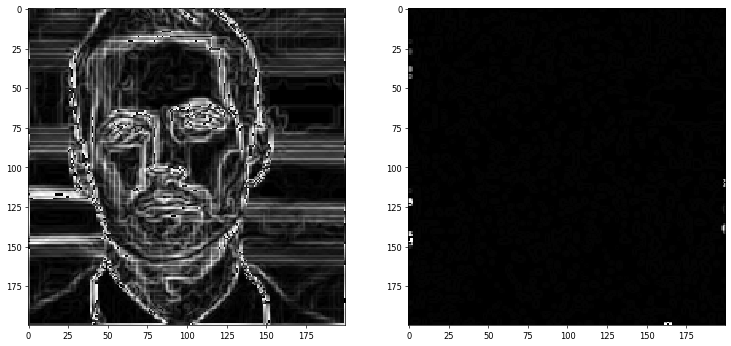

In [207]:
fig2 = plt.figure(figsize = [15,15], dpi = 60)
ax1 = fig2.add_subplot(121)
ax1.imshow(np.floor(energy_grad_interp_base).astype('uint8'), interpolation = None, cmap = 'gray')
ax2 = fig2.add_subplot(122)
ax2.imshow(np.floor(energy_grad_interp_detail).astype('uint8'), interpolation = None, cmap = 'gray')
plt.show()

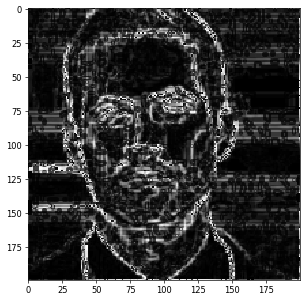

In [211]:
fig2 = plt.figure(figsize = [6,6], dpi = 60)
ax1 = fig2.add_subplot(111)
ax1.imshow(np.floor(enhance).astype('uint8'), interpolation = None, cmap = 'gray')
plt.show()

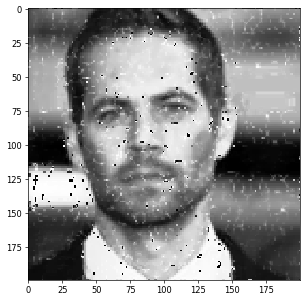

In [210]:
fig2 = plt.figure(figsize = [6,6], dpi = 60)
ax1 = fig2.add_subplot(111)
ax1.imshow(np.floor(interpolated_image-np.min(interpolated_image)).astype('uint8'), interpolation = None, cmap = 'gray')
plt.savefig('Resized photo.jpg')
plt.show()